# Train 3D network on Memento

In [1]:
# Imports
import sys
print("sys.executable:",sys.executable)

import numpy as np
import keras
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from keras.optimizers import Adam, SGD
import pickle
import json

sys.path.append('../src/')
from generator import VideoSeqGenerator, preprocess_rgb_fast, load_vids_opencv
from vid_utils import load_video_opencv, plot_frames
from memento_utils import *
from captioning_utils import *
import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2

# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

sys.executable: /usr/bin/python3


Using TensorFlow backend.
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
import keras
import tensorflow as tf
import numpy as np
print("keras version:", keras.__version__)
print("tf version:", tf.__version__)
print("np version:", np.__version__)

keras version: 2.3.1
tf version: 1.14.0
np version: 1.18.5


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [6]:
%%bash
nvidia-smi

Fri Jul 17 17:30:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1A:00.0 Off |                  N/A |
| 41%   37C    P8    25W / 280W |   2965MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:68:00.0  On |                  N/A |
| 41%   48C    P2    69W / 280W |  23541MiB / 24217MiB |     37%      Default |
+-------------------------------+----------------------+----------------------+
        

# Key vars

In [7]:
data_type = 'rgb'
dataset = 'memento10k'
gpus = 1
resc = 1
use_sw = 0
bs = 12
do = 0.3
loss_type = 'alphamse'

# Fetch video names, alphas, memorability scores and captions


In [9]:
if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if data_type=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
elif os.uname()[1] == 'cfosco-lambda':
    data_path = '../../../../../../Datasets/memento_raw/sources_numpy_256/' if data_type=='rgb' else '../../../../../../Datasets/memento_raw/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
else:
    data_path = '../../memento'
    labels_path = '../../memento_data'
    names_with_slash = True

    

train_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_train_data.json' 
val_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_val_data.json' 
test_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_test_data.json' 

train_names, val_names, test_names, name_to_mem_alpha, train_captions, val_captions, test_captions = get_memento_data(train_data, val_data, test_data)


str2label= {}
t = np.linspace(40,180,8).reshape(-1,1)
T=80
for name,(m,al) in name_to_mem_alpha.items():
#     print(name, m, al)
    str2label[name] =  np.array((t-T)*al + m)
#     print(str2label[name])

print('Loaded %d train videos, %d val videos, %d test videos\n' % (len(train_names), len(val_names), len(test_names)))


Loaded 7000 train videos, 1500 val videos, 1500 test videos



### Bert embedding dict structure:

key: video_name.npy

value: dict with keys "raw" and "embedded"
   - "raw": list of 5 string captions
   - "embedded": list of 5 1024 dimensional arrays

## Get mem weights if needed

In [10]:
if use_sw:
    factor = 3
    mem_weights = get_sample_weights([name_to_mem_alpha[n][0] for n in train_names], factor=factor)
    alpha_weights = get_sample_weights([name_to_mem_alpha[n][1] for n in train_names], factor=factor)
    
    sw=np.array(mem_weights)
else:
    sw=None

In [11]:
print([name_to_mem_alpha[n] for n in train_names][:10])
# print(mem_weights[:10])

[array([ 9.89151448e-01, -3.86640754e-04]), array([9.13390932e-01, 4.10293421e-04]), array([ 9.32910372e-01, -5.18010452e-04]), array([ 9.66062043e-01, -1.07779651e-04]), array([ 9.44807588e-01, -6.62044493e-04]), array([ 9.23569664e-01, -5.26515300e-04]), array([8.46147085e-01, 9.04769044e-06]), array([ 9.36736706e-01, -4.33197477e-04]), array([ 9.91672655e-01, -3.36745889e-04]), array([ 0.61340055, -0.00138345])]


# Generator

In [12]:
# Instantiating generator


gen_train = VideoSeqGenerator(files=np.array(train_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv= None, 
                            augment= None, #['dropout', 'cutout'],
                            load_func='npy_'+data_type,
                            load_labels_func='as_list',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=True,
                            is_train=True,
                            verbose=True,
                            str2label_dict = str2label,
                            sample_weights=sw)

gen_val = VideoSeqGenerator(files=np.array(val_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func='npy_'+data_type,
                            load_labels_func='as_list',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label,
                            sample_weights=sw)

gen_test = VideoSeqGenerator(files=np.array(test_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func='npy_'+data_type,
                            load_labels_func='as_list',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label,
                            sample_weights=sw)

gen_val_mini = VideoSeqGenerator(files=np.array(val_names)[:20],
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func='npy_'+data_type,
                            load_labels_func='as_list',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label,
                            sample_weights=sw)

Caution: batch_size (12) is not multiple of given dataset length (7000). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 7000 . Augmentation:  None
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 1500 . Augmentation:  None
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 1500 . Augmentation:  None
Caution: batch_size (12) is not multiple of given dataset length (20). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  12 . Number of files received: 20 . Augmentation:  None


# Test Generator


Total time on this batch: 0.5194313642568886  - it: 0 - idx: 0
Time loading: 0.29596545826643705
Time preprocessing: 0.223462815862149
Time augmenting: 3.0901283025741577e-06


mem over time labels: [[0.85066451]
 [0.82073701]
 [0.79080951]
 [0.76088201]
 [0.73095451]
 [0.70102701]
 [0.67109951]
 [0.64117201]]


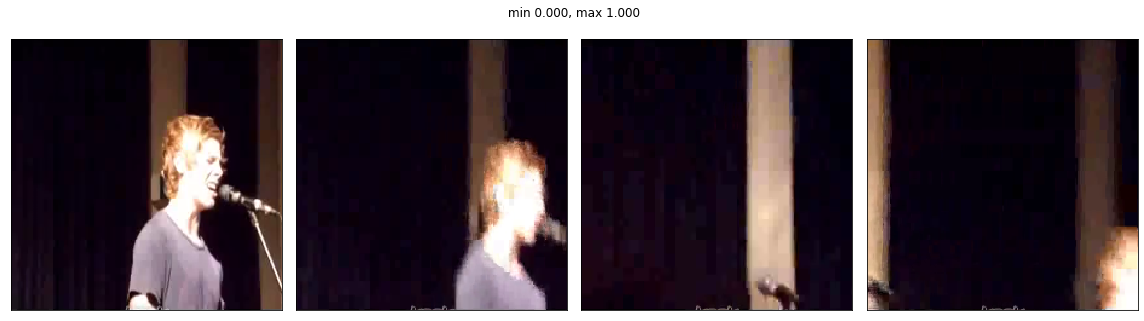



mem over time labels: [[0.89340264]
 [0.85919078]
 [0.82497893]
 [0.79076707]
 [0.75655522]
 [0.72234336]
 [0.68813151]
 [0.65391965]]




mem over time labels: [[0.81745951]
 [0.83794353]
 [0.85842754]
 [0.87891156]
 [0.89939557]
 [0.91987958]
 [0.9403636 ]
 [0.96084761]]


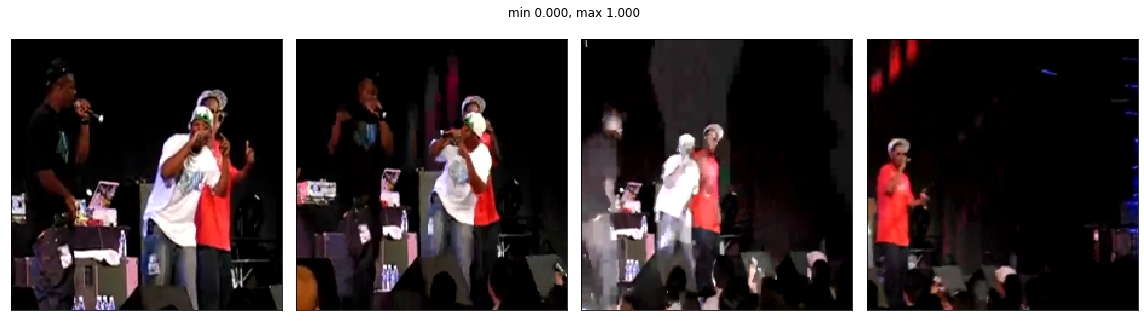



mem over time labels: [[0.79724632]
 [0.7079745 ]
 [0.61870267]
 [0.52943085]
 [0.44015902]
 [0.3508872 ]
 [0.26161537]
 [0.17234355]]


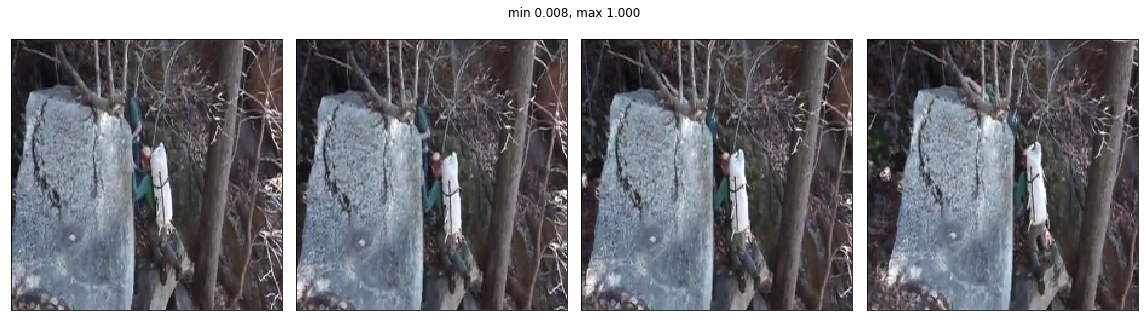



mem over time labels: [[0.98507736]
 [0.95219834]
 [0.91931932]
 [0.8864403 ]
 [0.85356128]
 [0.82068226]
 [0.78780324]
 [0.75492422]]




mem over time labels: [[0.94848949]
 [0.92086316]
 [0.89323683]
 [0.8656105 ]
 [0.83798416]
 [0.81035783]
 [0.7827315 ]
 [0.75510517]]


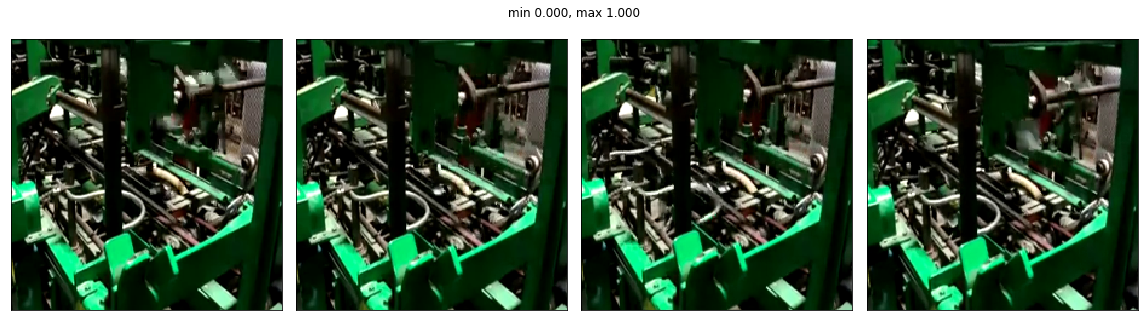



mem over time labels: [[0.99920336]
 [0.95430768]
 [0.909412  ]
 [0.86451632]
 [0.81962065]
 [0.77472497]
 [0.72982929]
 [0.68493361]]


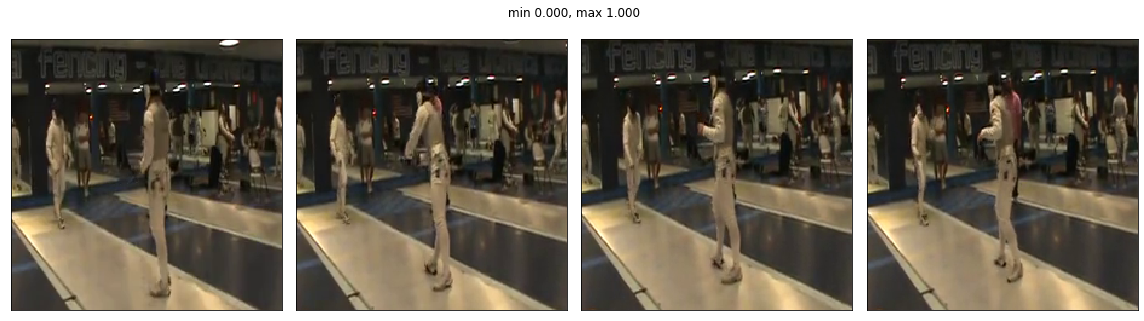



mem over time labels: [[0.95624324]
 [0.94928768]
 [0.94233213]
 [0.93537658]
 [0.92842103]
 [0.92146548]
 [0.91450993]
 [0.90755438]]


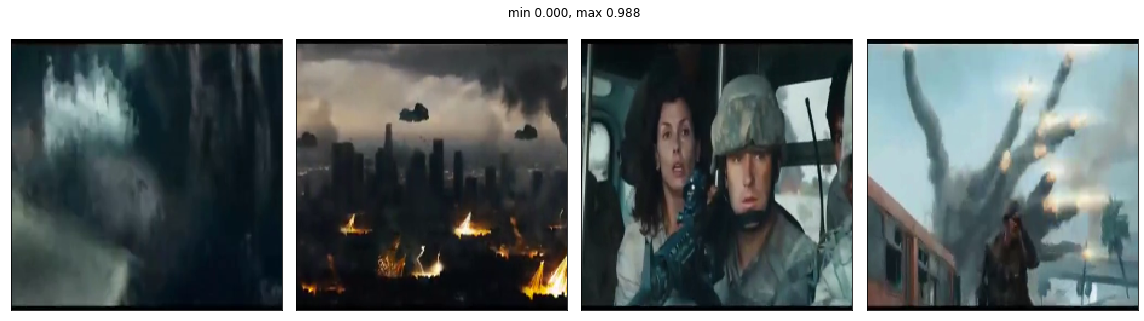



mem over time labels: [[0.91414871]
 [0.89303687]
 [0.87192504]
 [0.8508132 ]
 [0.82970137]
 [0.80858953]
 [0.7874777 ]
 [0.76636586]]


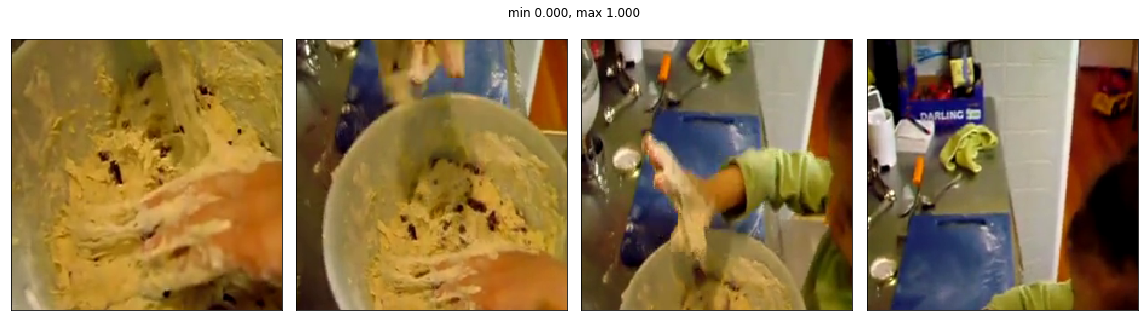



mem over time labels: [[0.9696352 ]
 [0.97375896]
 [0.97788271]
 [0.98200647]
 [0.98613022]
 [0.99025398]
 [0.99437773]
 [0.99850149]]


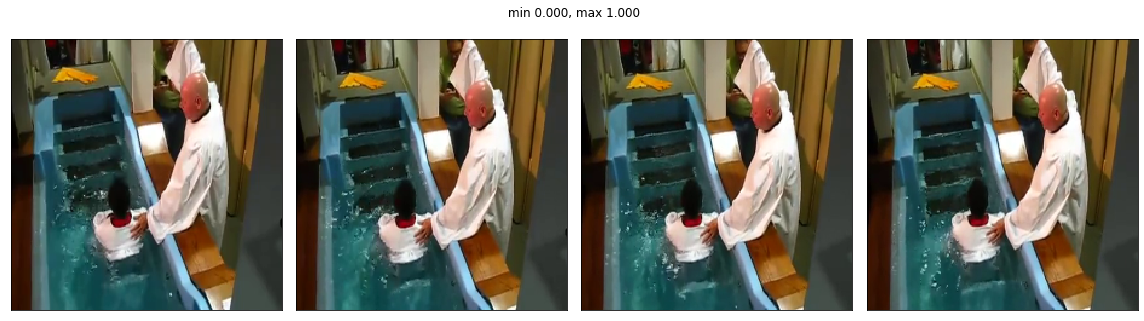



mem over time labels: [[0.89728625]
 [0.84244888]
 [0.78761151]
 [0.73277414]
 [0.67793677]
 [0.62309941]
 [0.56826204]
 [0.51342467]]


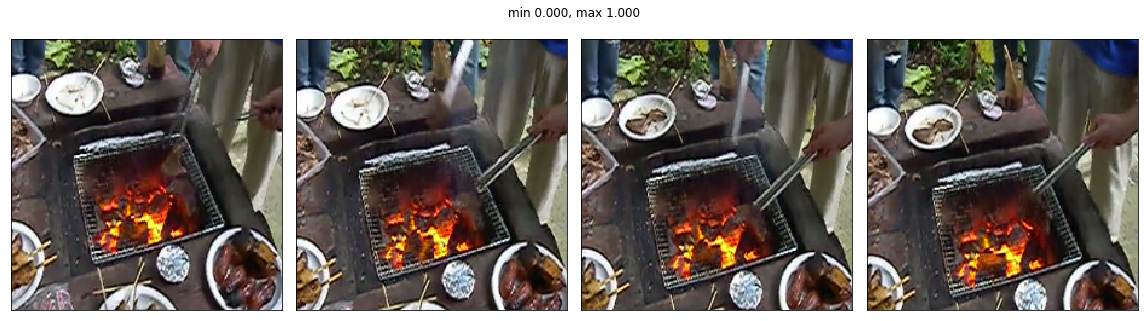



mem over time labels: [[0.91701435]
 [0.89066152]
 [0.86430869]
 [0.83795587]
 [0.81160304]
 [0.78525021]
 [0.75889738]
 [0.73254456]]


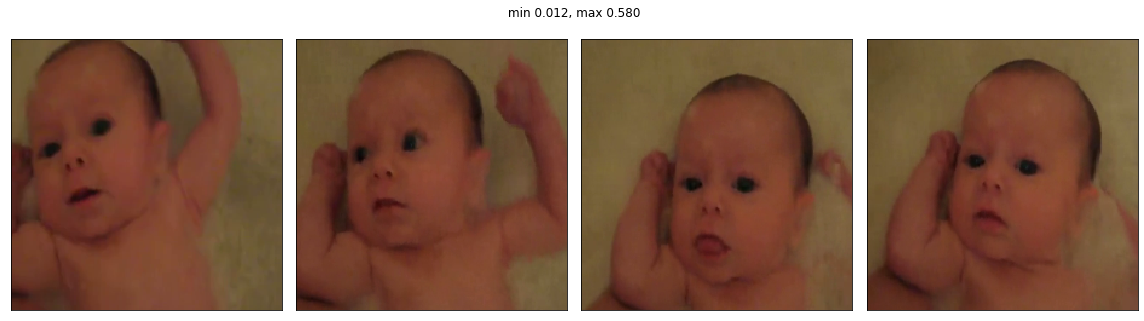

In [13]:
# Test with one batch of memento training

ret = gen_val.__getitem__(0) #np.random.randint(len(gen_val)))

video_batch=ret[0]
labels=ret[1]


# Display
for i,b in enumerate(video_batch):
    
    mot = labels[i]
    
    print("\n\nmem over time labels:", mot)
#     print('mem, alpha, np.max(b), np.min(b)',mem, alpha, np.max(b), np.min(b))
    
    plot_frames(b, 
#                 title='%s | %d frames. STM: %.3f. Alpha: %.5f' % ('vid',len(b),mem,alpha),
                is_optical_flow=True if data_type=='flow' else False,
                suptitle_y=0.89,
                is_255image=True, 
                frames_to_show=4)

# Model

In [14]:
# Fetching pretrained i3d


i3d = build_model_multigpu(type=data_type, 
                           model_type='i3d_rec',
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=1,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=do, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=resc)


Working with single GPU
x.shape after downsa: (?, 21, 28, 28, 192)
channels_last
x.shape after last conv: (?, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /home/camilo/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
video_repr shape before last conv (?, 5, 1, 1, 1024)
Model: "i3d_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 42, 224, 224, 3)   0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 42, 224, 224, 3)   0         
_________________________________________________________________
i3d_inception (Model)        multiple                  12294544  
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 1024)           0         
_________________________________________________________________

In [15]:
%%bash
cd ../ckpt/i3d_rec
ls

memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0135_valrc0.5605.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep01_valloss0.0155_valrc0.6124.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0125_valrc0.6117.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep02_valloss0.0179_valrc0.5835.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep03_valloss0.0095_valrc0.6078.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep03_valloss0.0212_valrc0.4435.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep03_valloss0.0231_valrc0.5675.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep04_valloss0.0130_valrc0.6136.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep05_valloss0.0135_valrc0.5955.hdf5
memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c10

In [16]:
# Load weights 
W = '../ckpt/i3d_rec/memento10k_rgb_fzn0_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep30_valloss0.0143_valrc0.6154.hdf5' #'../ckpt/i3d/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep07_valloss6.8248_valrc0.5935.hdf5' #None #'../ckpt/i3d/memento10k_flow_ep06_valloss8.8485.hdf5'
if W:
    i3d.load_weights(W)

# Train last layers

In [15]:
### print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    if l.name == 'i3d_inception':
        l.trainable=False
    if l.name == 'Conv3d_6a_1x1_conv':
        l.trainable=False

# Define optimizer
lr=0.0001
optimizer = Adam(lr=lr)

print('Compiling model')

# Compile model
a=0.1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse'])
    
## DEBUG
str2label_train= {}
str2label_val= {}
t = np.linspace(40,180,8).reshape(-1,1)
for name,(m,al) in name_to_mem_alpha.items():
#     print(name, m, al)
    str2label_train[name] =  np.array((t-T)*al + m)
    str2label_val[name] =  np.array((t-T)*al + m)
    
true_mem = np.zeros((8,len(val_names)))
for i,v in enumerate(val_names):
    true_mem[:,i] = str2label_val[v][0].flatten()
## DEBUG
    
use_rc=True
ckpt_filepath = get_ckpt_name('../ckpt/i3d_rec', dataset, data_type, True, resc, gpus, bs, loss_type, use_sw, do, a,b,c)
cbs = define_callbacks(ckpt_filepath, 
                       gen_val, 
                       name_to_mem_alpha, 
                       val_names, 
#                        true_mem=true_mem,
                       lr=lr, 
                       drop=0.1, 
                       epochs_drop=10, 
                       ckpt_period=1, 
                       use_cb_rankcorr=use_rc,)
#                        idx_to_look_at = [0,1,2,3,4,5,6,7])


print('Ready to train last layer')
print('ckpt_filepath:',ckpt_filepath)

# from copy import deepcopy
# gen_val_mini = deepcopy(gen_val)
# gen_val_mini.files = gen_val.files[:20]

# Training
i3d.fit_generator(gen_train, 
                  epochs=5,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val_mini,
                  workers=1,
                  steps_per_epoch=2)


Compiling model
Ready to train last layer
ckpt_filepath: ../ckpt/i3d_rec/memento10k_rgb_fzn1_resc1_LTalphamse_a0b100c1000_w0_gpus1_bs12_do0.30_ep{epoch:02d}_valloss{val_loss:.4f}_valrc{rc_val:.4f}.hdf5
Epoch 1/5

Total time on this batch: 0.659639734076336  - it: 0 - idx: 0
Time loading: 0.362682149047032
Time preprocessing: 0.29694664501585066
Time augmenting: 1.0940013453364372e-05

Total time on this batch: 0.6604439590591937  - it: 0 - idx: 211
Time loading: 0.3640331618953496
Time preprocessing: 0.29632355901412666
Time augmenting: 8.723814971745014e-05
2/2 [==============================] - 7s 4s/step - loss: 0.3148 - mse: 0.3148 - val_loss: 0.3151 - val_mse: 0.3151
PREDICTING FOR RANK CORRELATION....
125/125 [==============================] - 73s 582ms/step
preds[0][:5] [[0.2602595 ]
 [0.4782168 ]
 [0.6572891 ]
 [0.80256057]
 [0.9193942 ]]
len(preds) 1500
self.true_mem[:5] [[0.79080951 0.82497893 0.85842754 ... 0.88440439 0.86195352 0.80321046]]
Preds is not a list or has len le

# Train full network

In [17]:
print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    l.trainable = True

        
lr=0.0001
optimizer = Adam(lr=lr)

a=0.1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=['mse'],
              metrics=['mse'])
    
use_rc=True
ckpt_filepath = get_ckpt_name('../ckpt/i3d_rec', dataset, data_type, False, resc, gpus, bs, loss_type, use_sw, do, a,b,c)
cbs = define_callbacks(ckpt_filepath, 
                       gen_val, 
                       name_to_mem_alpha, 
                       val_names, 
                       lr=lr, 
                       drop=0.1, 
                       epochs_drop=10, 
                       ckpt_period=1, 
                       use_cb_rankcorr=use_rc)


    
print('Ready to train full net')

# Training
i3d.fit_generator(gen_train, 
                  epochs=30,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val, 
                  workers=10)


TRAINING WITH 1 GPUS
Ready to train full net
Epoch 1/30
288/583 [=============>................] - ETA: 6:26 - loss: 0.0143 - mse: 0.0143
Total time on this batch: 0.7481286469846964  - it: 500 - idx: 528
Time loading: 0.503791922936216
Time preprocessing: 0.24425560398958623
Time augmenting: 8.112005889415741e-05
583/583 [==============================] - 812s 1s/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0135 - val_mse: 0.0157
PREDICTING FOR RANK CORRELATION....
 88/125 [====================>.........] - ETA: 23s
Total time on this batch: 0.8599404180422425  - it: 1000 - idx: 98
Time loading: 0.6057607801631093
Time preprocessing: 0.25417374400421977
Time augmenting: 5.893874913454056e-06
125/125 [==============================] - 76s 608ms/step
preds[0][:5] [[0.801885  ]
 [0.7655768 ]
 [0.7224625 ]
 [0.66471386]
 [0.6142053 ]]
len(preds) 1500
self.true_mem[:5] [[0.79080951 0.82497893 0.85842754 ... 0.88440439 0.86195352 0.80321046]]
Preds is not a list or has len less than 5, p

KeyboardInterrupt: 

# Show some results

In [17]:
def show_results(model, inputs, labels):
    
    preds = model.predict(inputs)
    
    mem_and_alpha = preds[0]
    captions = preds[1]
    
    for i in range(len(mem_and_alpha)):
        
        predmem = mem_and_alpha[i][0]
        predalpha = mem_and_alpha[i][1]
        
        mem = labels[0][i][0]
        alpha = labels[0][i][1]
        
        pred_cap = captions[i]
        true_cap = labels[1][i]
        
        # Show input video, predicted mem and alpha with true mem and alpha
        plot_frames(inputs[0][i], 
                    title='pred mem: %.3f. True: %.3f. pred alpha: %.5f. True: %.5f --' % (predmem, mem, predalpha, alpha),
                    is_optical_flow=False,
                    suptitle_y=0.89,
                    is_255image=True, 
                    frames_to_show=4)
        
        # Print predicted caption and true caption
        if caption_format=='index_triangular_matrix':
            print("Input caption:", to_words(inputs[1][i]))
            print("word to predict:", to_words(np.argmax(true_cap)))
            print("predicted word:", to_words(np.argmax(pred_cap)))
        else:
            print("Input caption:", to_words(inputs[1][i]))
            print("seq to predict:", to_words([np.argmax(w) for w in true_cap]))
            print("predicted seq:", to_words([np.argmax(w) for w in pred_cap]))
            
    
        
show_results(i3d, *gen_val.__getitem__(2))

IndexError: index 1 is out of bounds for axis 0 with size 1

# Predict and Evaluate RC at different times

In [18]:
# Load model if necessary
# W = '../ckpt/i3d/memento10k_flow_ep10_valloss11.7493.hdf5'
# i3d.load_weights(W)

In [32]:
# Predict
gen_eval = VideoSeqGenerator(files=np.array(test_names),
                            batch_size=1, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func='npy_'+data_type,
                            load_labels_func='as_list',
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label,
                            sample_weights=sw)

preds = i3d.predict_generator(gen_eval, verbose=1)

Calling VideoSeqGenerator. Batch size:  1 . Number of files received: 1500 . Augmentation:  None

Total time on this batch: 0.08084404235705733  - it: 0 - idx: 0
Time loading: 0.047896561212837696
Time preprocessing: 0.03294404922053218
Time augmenting: 3.4319236874580383e-06
 498/1500 [========>.....................] - ETA: 43s
Total time on this batch: 0.04204855067655444  - it: 500 - idx: 500
Time loading: 0.028415740001946688
Time preprocessing: 0.013628921005874872
Time augmenting: 3.889668732881546e-06
 998/1500 [==================>...........] - ETA: 22s
Total time on this batch: 0.044810772873461246  - it: 1000 - idx: 1000
Time loading: 0.02606881782412529
Time preprocessing: 0.018738289829343557
Time augmenting: 3.6652199923992157e-06
1500/1500 [==============================] - 66s 44ms/step


In [33]:
print(preds)

[[[0.9206931 ]
  [0.92207736]
  [0.9170594 ]
  ...
  [0.89900804]
  [0.89184225]
  [0.8850133 ]]

 [[0.93326855]
  [0.92507726]
  [0.91326696]
  ...
  [0.87298083]
  [0.85917336]
  [0.84609896]]

 [[0.8214788 ]
  [0.7816195 ]
  [0.73691285]
  ...
  [0.608442  ]
  [0.56665856]
  [0.52773803]]

 ...

 [[0.98153436]
  [0.96711284]
  [0.9560549 ]
  ...
  [0.925417  ]
  [0.91572726]
  [0.9068099 ]]

 [[0.8550022 ]
  [0.8185599 ]
  [0.7836211 ]
  ...
  [0.6898292 ]
  [0.6563916 ]
  [0.621463  ]]

 [[0.9246548 ]
  [0.88427156]
  [0.84775597]
  ...
  [0.74903315]
  [0.71827453]
  [0.6893864 ]]]


In [63]:
# import pickle
# pickle.dump(preds, open( "../preds/preds_rec_head_all_valrc0.6154.pkl", "wb" ) )

# pickle.dump([p[2] for p in preds], open( "../preds/preds_rec_head_T=80_valrc0.6154.pkl", "wb" ) )

In [34]:
# pred_mem = [p[0] for p in preds]
# pred_alpha = [p[1] for p in preds]

# true_mem=[]
# true_alpha=[]

# # verbose=False

# for i,n in enumerate(test_names):
# #     if verbose:
# #         print('Name:',n)
# #         print('True mem:',name_to_mem_alpha[n][0])
# #         print('Pred mem:',pred_mem[i])
# #         print('True alpha:',name_to_mem_alpha[n][1])
# #         print('Pred alpha:',pred_alpha[i])
#     true_mem.append(name_to_mem_alpha[n][0])
#     true_alpha.append(name_to_mem_alpha[n][1])

    
# true_mem = np.array(true_mem)
# true_alpha = np.array(true_alpha)
    
# print('First 8 gt mem:', true_mem[:8])
# print('First 8 pred mem:', pred_mem[:8])

# # assert(len(preds)==len(val_names))

# rc = spearmanr(pred_mem, true_mem)
# alpha_rc = spearmanr(pred_alpha, true_alpha)


# print('RC:', rc[0])
# print('Alpha_rc:',alpha_rc[0])

import scipy

def calculate_rc_rec(pred_mem, true_mem, true_alpha, t=80, ref_T=T):
    
    t_to_idx = {lag:i for i,lag in enumerate(np.linspace(40,180,8))}
    
    pred_at_t = np.array([p[t_to_idx[t]] for p in pred_mem]).flatten()
    gt_at_t = np.array((t-ref_T)*true_alpha[:len(pred_at_t)] + true_mem[:len(pred_at_t)]).flatten()
    
    
    return scipy.stats.spearmanr(pred_at_t, gt_at_t)[0]

for t in np.linspace(40,180,8):
    print(t)
    print(calculate_rc_rec(preds, true_mem, true_alpha, t=t, ref_T=80))

40.0
0.5425892821153953
60.0
0.5969736009633548
80.0
0.5990217120976692
100.0
0.5777499337357482
120.0
0.5479502440205086
140.0
0.5189105231049623
160.0
0.4929496328602365
180.0
0.4705602775300083


In [35]:
# Calculate R2
from sklearn.metrics import r2_score

def calculate_r2_rec(pred_mem, true_mem, true_alpha, t=80, ref_T=T):
    
    t_to_idx = {lag:i for i,lag in enumerate(np.linspace(40,180,8))}
    
    pred_at_t = np.array([p[t_to_idx[t]] for p in pred_mem]).flatten()
    gt_at_t = np.array((t-ref_T)*true_alpha[:len(pred_at_t)] + true_mem[:len(pred_at_t)]).flatten()
    
    print(pred_at_t[:10])
    print(gt_at_t[:10])
    
    print("len(pred_at_t)", len(pred_at_t))
    print("len(gt_at_t)", len(gt_at_t))
    
    print("mse", np.mean((pred_at_t-gt_at_t)**2 ))
    
    return r2_score(gt_at_t, pred_at_t)
    
    
for t in np.linspace(40,180,8):
    print()
    print(t)
    print("r2:", calculate_r2_rec(preds, true_mem, true_alpha, t=t, ref_T=80))


40.0
[0.9206931  0.93326855 0.8214788  0.87379295 0.857014   0.905053
 0.9562923  0.9239411  0.82525235 0.83770025]
[0.99983434 1.         0.77081099 0.97315969 0.8947269  0.97469866
 0.97867788 0.98320549 0.90458923 0.87346208]
len(pred_at_t) 1500
len(gt_at_t) 1500
mse 0.005849649460309969
r2: 0.2980331470367179

60.0
[0.92207736 0.92507726 0.7816195  0.852686   0.8400311  0.8861398
 0.93298876 0.8882184  0.79093724 0.83641607]
[0.9706618  1.         0.72998069 0.95694049 0.86910889 0.939347
 0.96626376 0.96867365 0.87684841 0.86027879]
len(pred_at_t) 1500
len(gt_at_t) 1500
mse 0.0059226724683165794
r2: 0.3608446294287112

80.0
[0.9170594  0.91326696 0.73691285 0.82813174 0.8109493  0.86198217
 0.9098632  0.86226004 0.7494078  0.8224801 ]
[0.94148925 1.         0.68915039 0.94072129 0.84349089 0.90399533
 0.95384964 0.95414182 0.84910759 0.84709551]
len(pred_at_t) 1500
len(gt_at_t) 1500
mse 0.007087258380117532
r2: 0.3647553545209222

100.0
[0.91294354 0.90150714 0.6951161  0.8014723

In [29]:
# import pickle
# def average_with_flow_and_va(file_flow, file_va, preds):
#     flow_dict = pickle.load(open(file_flow, 'rb'))
#     va_dict = pickle.load(open(file_va, 'rb'))
    
#     print(preds.shape)
    
#     average = 0.5*np.array(list(va_dict.values())) + 0.25*np.array(list(flow_dict.values())) + 0.25*np.array([p[2] for p in preds])
    
#     return average
    
# avg_preds = average_with_flow_and_va('../preds/flow_only0.5768269121.pkl', '../preds/va_only0.6012401.pkl', preds)

In [30]:
# for t in np.linspace(40,180,8):
#     print()
#     print("T=",t)
#     print("RC:",calculate_rc_rec(avg_preds, true_mem, true_alpha, t=t, ref_T=80))
#     print("r2:",calculate_r2_rec(avg_preds, true_mem, true_alpha, t=t, ref_T=80))

# Calculate R2 for the non-rec predictions



In [31]:
# Load best video-only model predictions
mem_alpha_preds = json.load(open("cap_mem_alpha_dict_0.6023.json"))

pred_mem = []
pred_alpha = []
true_mem = []
true_alpha = []

for k,v in mem_alpha_preds.items():
    pred_mem.append(v['pred_mem_score'])
    pred_alpha.append(v['pred_alpha'])
    true_mem.append(v['gt_mem_score'])
    true_alpha.append(v['gt_alpha'])

pred_mem = np.array(pred_mem)
pred_alpha = np.array(pred_alpha)
true_mem = np.array(true_mem)
true_alpha = np.array(true_alpha)
    
    
# create mem values at each t and Compute R2
def calculate_r2_nonrec(pred_mem, true_mem, pred_alpha, true_alpha, t=80, ref_T=T):
    
    t_to_idx = {lag:i for i,lag in enumerate(np.linspace(40,180,8))}
    
    pred_at_t = np.array((t-ref_T)*pred_alpha + pred_mem).flatten()
    gt_at_t = np.array((t-ref_T)*true_alpha + true_mem).flatten()  #[:len(pred_at_t)]
    
    print("mse", np.mean((pred_at_t-gt_at_t)**2 ))
    print("r2:", r2_score(gt_at_t, pred_at_t))
    print("RC:", scipy.stats.spearmanr(gt_at_t, pred_at_t)[0])
    
    return r2_score(gt_at_t, pred_at_t)
    
    
for t in np.linspace(40,180,8):
    print()
    print("t =",t)
    calculate_r2_nonrec(pred_mem, true_mem, pred_alpha, true_alpha, t=t, ref_T=80)



t = 40.0
mse 0.007114632834652065
r2: 0.14623321366246378
RC: 0.5538969062243111

t = 60.0
mse 0.0073178306799755
r2: 0.21028373507760212
RC: 0.5981041170223669

t = 80.0
mse 0.008623019625522548
r2: 0.22710211040967287
RC: 0.60413888948763

t = 100.0
mse 0.011030199671293204
r2: 0.21236646902108336
RC: 0.587605052791228

t = 120.0
mse 0.014539370817287478
r2: 0.18358842558661648
RC: 0.5618921524515275

t = 140.0
mse 0.019150533063505365
r2: 0.15153036665352904
RC: 0.5335525380531747

t = 160.0
mse 0.02486368640994686
r2: 0.12110257328427254
RC: 0.5064958291150314

t = 180.0
mse 0.031678830856611974
r2: 0.09400391330802049
RC: 0.4813566534752741


# Generate captions with different representations

In [ ]:
# Use the different vectors outputted by the LSTM to generate varied captions